# Instacart Market Basket Analysis

This data and challenge comes from [this kaggle competition](https://www.kaggle.com/c/instacart-market-basket-analysis/overview).

## Problem Statement

Instacart is an American company that operates a grocery delivery and pick-up service in the United States and Canada. The company offers its services via a website and mobile app. The service allows customers to order groceries from participating retailers with the shopping being done by a personal shopper. It offers same-day delivery and pickup services for retailers and consumers [[1]](https://en.wikipedia.org/wiki/Instacart).

As more and more customers moves to online grocery in recent years, Instacart would like to make effort to increase customer retention rate. Customer retention is the best way to scale business at an affordable cost.High customer retention rates also increase profitability. 

As data scientists of Instacart, we woulkd like to apply machine learning to predict whether customers will purchase the products in their next order. Based on the prediction result, we can make recommendation for customers. This will make it easy for customers to search for these respective products and reorder it, hence promote customer satisfaction and increase customer retention rate.

## Executive Summery

As online groceries shoppings increase rapidly, especially during Covid19 period, Instacart would like to increase customer experience when ordering from Instacart App. They expect their customer to search the products that they needs more easily and time-efficiently. 

As data scientists, we would like to utilise ordering historical data to build machine learning models to predict whether customer will reorder certain products. With predicted results, Instacart can recommend these products to customer for next order. This will promote customer shopping experience and increase Instacart revenue at the same time. 

In this project, we build some binary classification models , such as basic model (Logistic Regression), boosting models (XGBoost and Lightgbm), bagging model (Random Forest). Amongst these models, random forest performance best. However, due to large dataset, it requests quite long time to train random forest model. The second best performance models are boost models, i.e. XGBoost and Lightgbm. They requires shorter time to train, especially Lightgbm model needs even shorter time than XGBoost. Not surprisely, the third best performance model is Logistic Regression due to its naive nature. However, the perfromance gap betweem Random Forest & Logistic Regression is not that much. If we would like to obtain rough result quickly and we can apply logistic regression model.   

## Import library and load datasets

In [1]:
#import libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import random

In [2]:
# import datases. Total 6 datasets
aisles=pd.read_csv('../data/aisles.csv')
dept=pd.read_csv('../data/departments.csv')
order_prior=pd.read_csv('../data/order_products__prior.csv')
order_train=pd.read_csv('../data/order_products__train.csv')
order_all=pd.read_csv('../data/orders.csv')
product=pd.read_csv('../data/products.csv')

## Data Cleaning and Imputation

### Aisles data

There are total 134 aisles and no null or deplicated values.

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
aisles.shape

(134, 2)

In [5]:
aisles.nunique()

aisle_id    134
aisle       134
dtype: int64

In [6]:
aisles.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

In [7]:
aisles.duplicated().sum()

0

### Department data

There are total 21 departments and no null or deplicated values.

In [8]:
dept.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [9]:
dept.shape

(21, 2)

In [10]:
dept.nunique()

department_id    21
department       21
dtype: int64

In [11]:
dept.isnull().sum()

department_id    0
department       0
dtype: int64

In [12]:
dept.duplicated().sum()

0

### Order prior data

Order prior data consists of all product details for any prior order, including 4 columns, i.e. order_id, product_id, add_tocart_order and whether reordered. There is no null or deplicated values. 

In [13]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
order_prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [15]:
order_prior.duplicated().sum()

0

### Order train data

Order train data is similar with order prior data. It consists of all product details for train data, including 4 columns, i.e. order_id, product_id, add_tocart_order and whether reordered. There is no null or deplicated values. 

In [16]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [17]:
order_train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [18]:
order_train.shape

(1384617, 4)

In [19]:
order_train.duplicated().sum()

0

### Order_all data

Orders_all dataset consists of order details placed by any user, including prior/train/test orders. 
Prior set contains first n-1 orders for all 206209 users. Train set contains order information of last order of 131209 users and test set contains last order information of 75000 users. 

Inside order_all, it can be seen that for every user’s 1st order ( order_number = 1) the days_since_prior_order is Nan, which makes sense. We can impute 0 here.

In [20]:
order_all.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [21]:
# There is total 206209 user_ids
order_all['user_id'].nunique()

206209

In [22]:
# There is total 206209 user_ids in prior set.
order_all.loc[order_all['eval_set']=='prior','user_id'].nunique()

206209

In [23]:
# There is total 131209 user_ids in train set.
order_all.loc[order_all['eval_set']=='train','user_id'].nunique()

131209

In [24]:
# There is total 75000 user_ids in test set.
order_all.loc[order_all['eval_set']=='test','user_id'].nunique()

75000

In [25]:
order_all.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [26]:
order_all.isnull().sum()/order_all.shape[0]

order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    0.060276
dtype: float64

In [27]:
order_all.fillna(0, inplace=True)

In [28]:
order_all.duplicated().sum()

0

### product data

Producst dataset provides the details of products, i.e. product_id, product_name and the aisles/department that products belong to. Total 49688 productd. There is no null or deplicated value. 

In [29]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [30]:
product.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64

In [31]:
product.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [32]:
product.duplicated().sum()

0

## EDA

### Merge all the data for prior

In [33]:
merged_df = pd.merge(left = order_prior, 
                     right = product,
                     left_on='product_id', 
                     right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)

merged_df = pd.merge(left = merged_df, 
                     right = aisles,
                     left_on='aisle_id', 
                     right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)

merged_df = pd.merge(left = merged_df, 
                     right = dept,
                     left_on='department_id', 
                     right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)

merged_df = pd.merge(left = merged_df, 
                     right = order_all,
                     left_on='order_id', 
                     right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

col_order = ['user_id','order_id','product_id','aisle_id','department_id','add_to_cart_order',
 'reordered','product_name','aisle','department','eval_set','order_number','order_dow','order_hour_of_day',
 'days_since_prior_order']

merged_df = merged_df[col_order]

## EDA about orders

### How Many Orders ?

Most users made few orders. The number of orders a users made decrease significantly along the order numbers.For every user_id, the order count was between 4-100 including train and test. Histogram shows that there are few users who have placed orders more than 60. 

In [35]:
order_count = order_all.groupby('user_id')['order_id'].count().to_frame()
order_count.columns=['order_count']

In [36]:
order_min=order_count['order_count'].min()
prder_max=order_count['order_count'].max()
print(f'The minimum order count is {order_min}')
print(f'The maximum order_count is {prder_max}')

The minimum order count is 4
The maximum order_count is 100


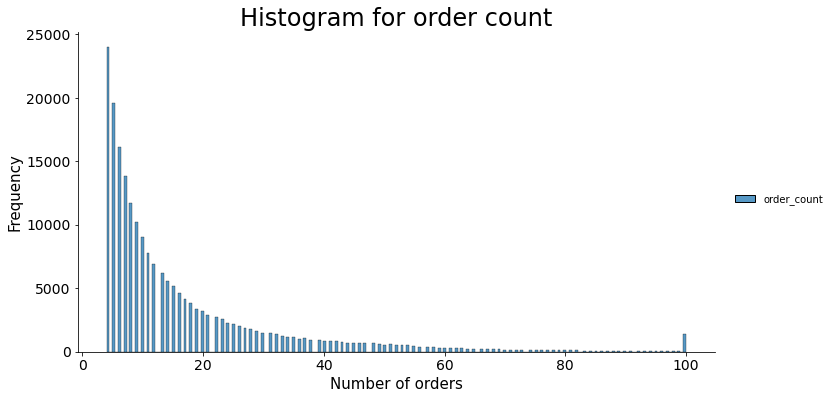

In [144]:
sns.displot(order_count, aspect=2)
plt.title("Histogram for order count", size=24)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Number of orders', size=15)
plt.ylabel('Frequency', size=15)
plt.show();

#### How Soon Until Next Order or reordered ?

For both order and reordered, it is very obvious that most users made their orders weekly (every 7 days) and monthly (every 30 days). See the peak of day 7 and day 30 for all orders. However, from reordered perspective,day 30 is relatively lower comparing to all orders pattern.

In [38]:
since_prior_order = merged_df.groupby('days_since_prior_order')['order_id'].count().to_frame(name='all_orders')
since_prior_order_reorder = merged_df[merged_df['reordered']==1].groupby('days_since_prior_order')['order_id'].count()
since_prior_order['reorders']=since_prior_order_reorder

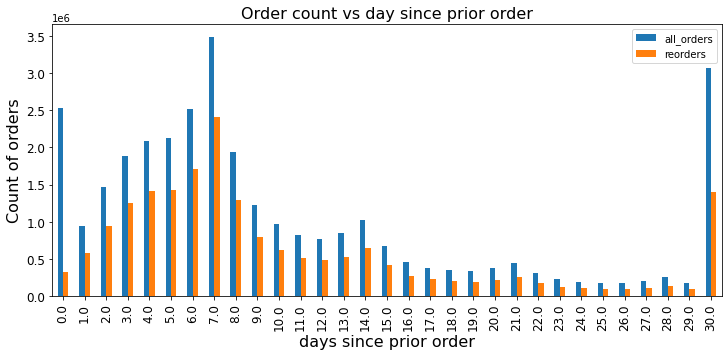

In [145]:
since_prior_order.plot(kind='bar', legend=True, figsize=(12,5))
plt.xticks(size=12)
plt.xlabel('days since prior order', size=16)
plt.ylabel('Count of orders', size=16)
plt.yticks(size=12)
plt.title('Order count vs day since prior order', size=16);

### EDA about Orders_Products

#### Most Popular Products reordered

The barplots shows for top20 products according to order count and reorder count. We can observe that banana is the most popular product, followed by bags of organic bananas and organic strawberries. We also can see that organic products are quite popular, 15 organics products out of top20. We also observe the same patten for reorder count, except organic whole milk and organic raspberries. 

In [40]:
product_order = merged_df.groupby('product_name')['order_id'].count().to_frame(name='all_orders').reset_index()
product_order

,product_name,all_orders
0,#2 Coffee Filters,777
1,#2 Cone White Coffee Filters,13
2,#2 Mechanical Pencils,8
3,#4 Natural Brown Coffee Filters,241
4,& Go! Hazelnut Spread + Pretzel Sticks,164
...,...,...
49672,with Xylitol Unwrapped Original Flavor 50 Stic...,37
49673,with Xylitol Unwrapped Spearmint 50 Sticks Sug...,55
49674,with Xylitol Watermelon Twist 18 Sticks Sugar ...,68
49675,with a Splash of Mango Coconut Water,23


In [41]:
product_reordered = merged_df.groupby('product_name')['reordered'].sum().to_frame(name='reordered').reset_index()
product_reordered

,product_name,reordered
0,#2 Coffee Filters,257
1,#2 Cone White Coffee Filters,3
2,#2 Mechanical Pencils,0
3,#4 Natural Brown Coffee Filters,89
4,& Go! Hazelnut Spread + Pretzel Sticks,87
...,...,...
49672,with Xylitol Unwrapped Original Flavor 50 Stic...,17
49673,with Xylitol Unwrapped Spearmint 50 Sticks Sug...,19
49674,with Xylitol Watermelon Twist 18 Sticks Sugar ...,31
49675,with a Splash of Mango Coconut Water,6


In [42]:
product_order=product_order.merge(product_reordered, on='product_name').sort_values('all_orders', ascending=False)

In [43]:
product_order.set_index('product_name', inplace=True)

<Figure size 864x360 with 0 Axes>

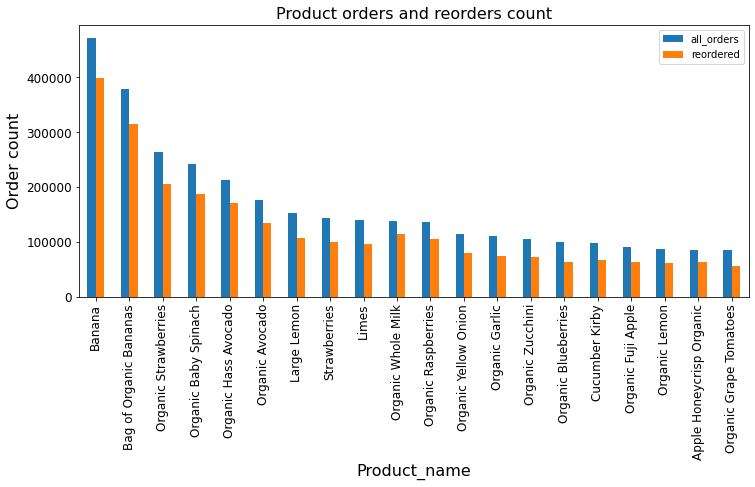

In [44]:
plt.figure(figsize=(12,5))
product_order[0:20].plot(kind='bar', legend=True, figsize=(12,5))
plt.xticks(rotation=90, size=12)
plt.xlabel('Product_name', size=16)
plt.ylabel('Order count', size=16)
plt.yticks(size=12)
plt.title('Product orders and reorders count', size=16);

In [45]:
product_reordered = ((merged_df.groupby('product_name')['reordered'].sum()*100)/merged_df.shape[0]).sort_values(ascending=False).to_frame()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


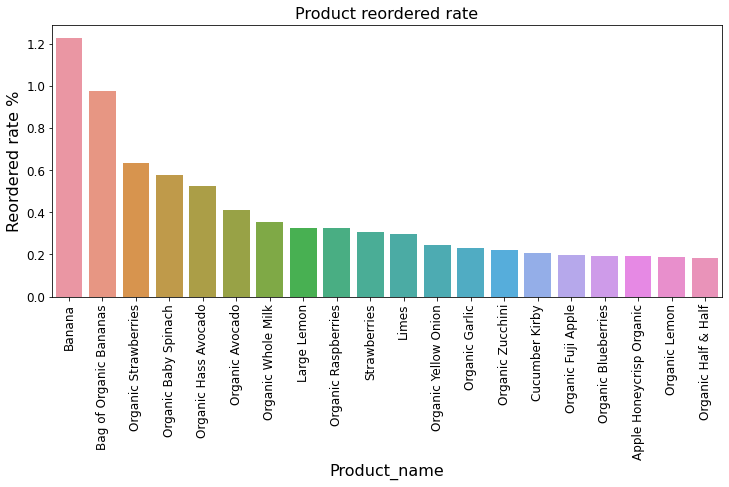

In [46]:
plt.figure(figsize=(12,5))
sns.barplot(product_reordered.index[0:20], product_reordered['reordered'].head(20))
plt.xticks(rotation=90, size=12)
plt.xlabel('Product_name', size=16)
plt.ylabel('Reordered rate %', size=16)
plt.yticks(size=12)
plt.title('Product reordered rate', size=16);

#### Most Popular aisle reordered

Chart below shows top 20 aisles. We looked into the buying trend of product by aisles and notice that certain aisle like vegetables and fruits contributes to almost 15% of total reorders. 

In [47]:
aisle_reordered = ((merged_df.groupby('aisle')['reordered'].sum()*100)/merged_df.shape[0]).sort_values(ascending=False).to_frame()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


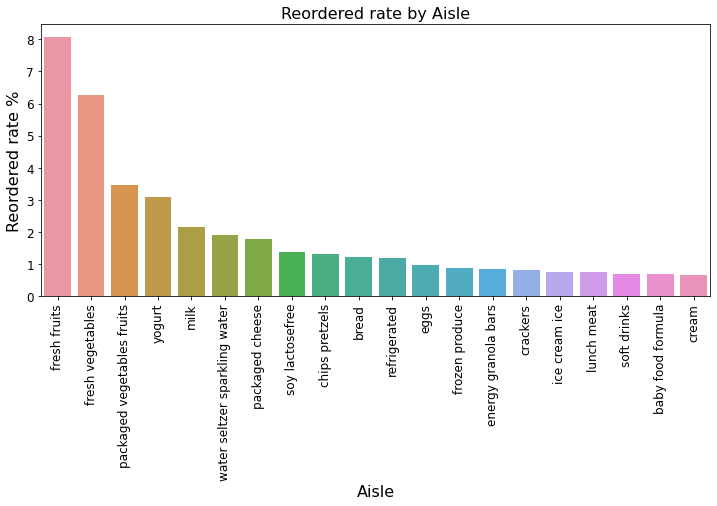

In [146]:
plt.figure(figsize=(12,5))
sns.barplot(aisle_reordered.index[0:20], aisle_reordered['reordered'].head(20))
plt.xticks(rotation=90, size=12)
plt.xlabel('Aisle', size=16)
plt.ylabel('Reordered rate %', size=16)
plt.yticks(size=12)
plt.title('Reordered rate by Aisle', size=16);

#### Most Popular Department reordered

Certain departments are clearly more popular, like produce and dairy eggs. Both departments combined contributed to nearly 30% of total reorders.

In [49]:
dept_reordered = ((merged_df.groupby('department')['reordered'].sum()*100)/merged_df.shape[0]).sort_values(ascending=False).to_frame()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


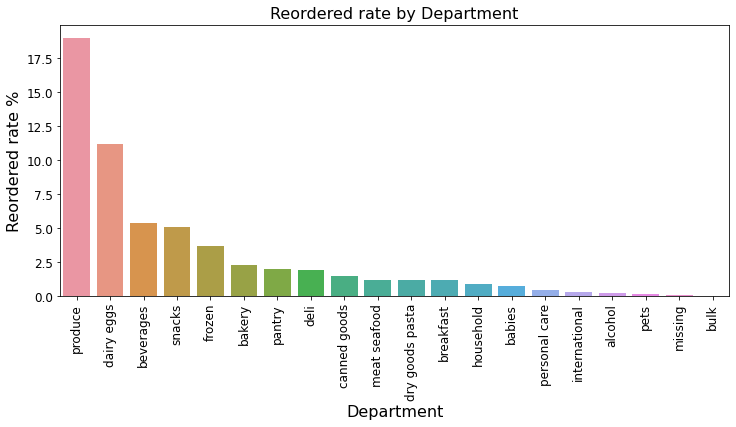

In [147]:
plt.figure(figsize=(12,5))
sns.barplot(dept_reordered.index[0:20], dept_reordered['reordered'].head(20))
plt.xticks(rotation=90, size=12)
plt.xlabel('Department', size=16)
plt.ylabel('Reordered rate %', size=16)
plt.yticks(size=12)
plt.title('Reordered rate by Department', size=16);

### EDA about Cart size distribution

Number of items in all orders range from 1 to 145. The histogram below is highly skewed towards small cart size. Majority of users purchased 5-6 items in their orders.

In [51]:
cart_size = merged_df.groupby('order_id')['add_to_cart_order'].count()

In [52]:
print(f'The minimum cart_size is {cart_size.min()}')
print(f'The maximum cart_size is {cart_size.max()}')

The minimum cart_size is 1
The maximum cart_size is 145


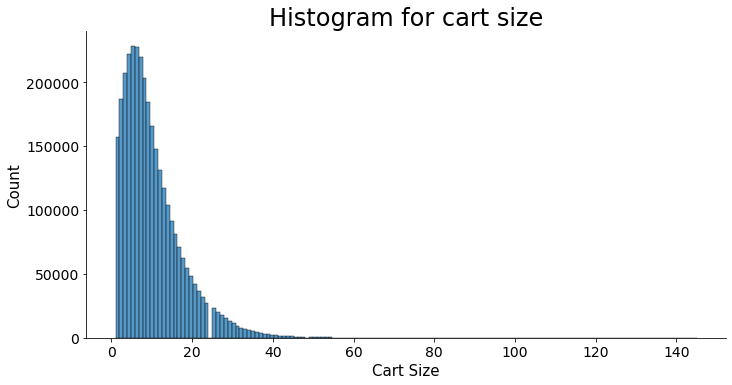

In [53]:
sns.displot(cart_size, bins=150, height=5, aspect=2)
plt.title("Histogram for cart size", size=24)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Cart Size', size=15)
plt.ylabel('Count', size=15)
plt.show();

### EDA of daily/hourly orders or reorders pattern

#### Day Of Order and reorder

We can see that both Day 0 and Day 1 stand out to be the most busy shopping day for instacart. It is reasonable because people has more free time to place orders during weekends. We also observe that for higher orders, the reorders are also higher regarding to day.

In [54]:
order_week = merged_df.groupby('order_dow')['order_id'].count().to_frame(name='all_orders')
order_week_reordered = merged_df[merged_df['reordered']==1].groupby('order_dow')['order_id'].count()
order_week['reorders']=order_week_reordered

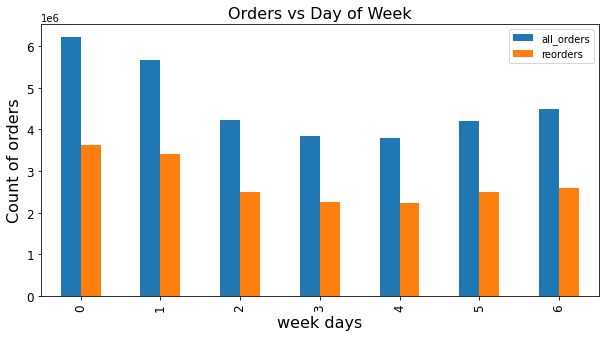

In [55]:
order_week.plot(kind='bar', legend=True, figsize=(10,5))
plt.xticks(size=12)
plt.xlabel('week days', size=16)
plt.ylabel('Count of orders', size=16)
plt.yticks(size=12)
plt.title('Orders vs Day of Week', size=16);

#### Hour Of Order and reorder

There are high peaks for order and reorder in the morning hours and it slowly gets decreases. Between 10 am to 15 pm there is a high order ratio amongst users. As we observe regards to day, we also observe that reorders and orders are also highly positive correlated regards to hour. 

In [56]:
order_day = merged_df.groupby('order_hour_of_day')['order_id'].count().to_frame(name='all_orders')
order_day_reordered = merged_df[merged_df['reordered']==1].groupby('order_hour_of_day')['order_id'].count()
order_day['reorders']=order_day_reordered

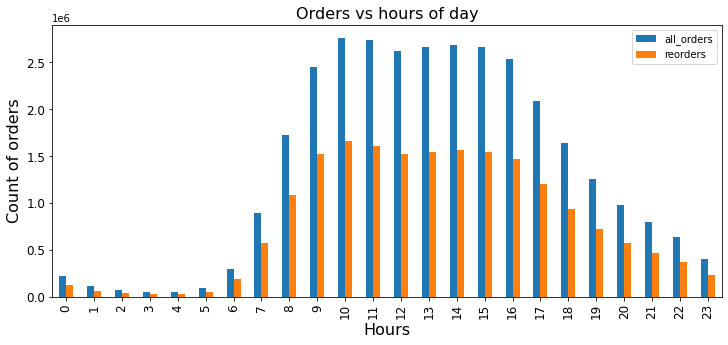

In [57]:
order_day.plot(kind='bar', legend=True, figsize=(12,5))
plt.xticks(size=12)
plt.xlabel('Hours', size=16)
plt.ylabel('Count of orders', size=16)
plt.yticks(size=12)
plt.title('Orders vs hours of day', size=16);

#### Day and hour orders heatmap

We can see the most of the orders are placed on the 0th day between 13-15 hour and 1st day between 9-11 hour. Also we can see that most of the orders on any given day are placed in between 8-18th hour.

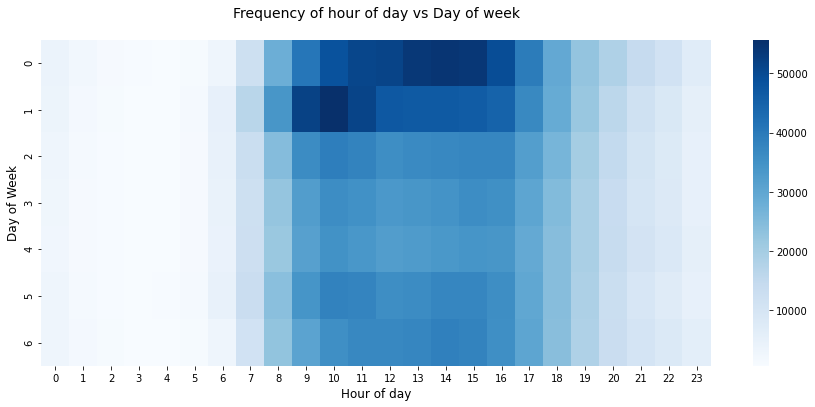

In [58]:
day_hour_df = order_all.groupby(['order_dow', 'order_hour_of_day'])['order_id'].aggregate("count").reset_index()
day_hour_df = day_hour_df.pivot('order_dow', 'order_hour_of_day', 'order_id')
plt.figure(figsize=(15, 6))
sns.heatmap(day_hour_df, cmap='Blues')#YlGn
plt.xlabel('Hour of day', size=12)
plt.ylabel('Day of Week', size=12)
plt.title('Frequency of hour of day vs Day of week\n', size=14);

## Feature Engineering

Our purpose is to predict user-product pairwise repeat purchase according to the purchase history. We will create user, product and user-product related features from prior data.

### Create features related to the users

In [59]:
#How frequent a customer has reordered products
user_reordered = merged_df.groupby('user_id')['reordered'].mean().to_frame('user_reorder_ratio').reset_index()
user_reordered.head()

,user_id,user_reorder_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [60]:
#no of products for each order
prd_per_order = merged_df.groupby(['user_id', 'order_id'])['product_id'].count().to_frame('products_per_order').reset_index()
prd_per_order.head(10)

,user_id,order_id,products_per_order
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,2254736,5
4,1,2295261,6
5,1,2398795,6
6,1,2539329,5
7,1,2550362,9
8,1,3108588,6
9,1,3367565,4


In [61]:
# average no of products for each user
user_avg_products = prd_per_order.groupby(by=['user_id'])['products_per_order'].mean().to_frame('user_avg_prd').reset_index()
user_avg_products.head()

,user_id,user_avg_prd
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000


In [62]:
# Average day between orders
mean_day_since_order=merged_df.groupby('user_id')['days_since_prior_order'].mean().to_frame('mean_day_since_order').reset_index()

mean_day_since_order

#### User tastes variance:number of unique aisles for user

In [64]:
user_aisle_count=merged_df.groupby('user_id')['aisle'].unique().to_frame('aisle_lst').reset_index()
user_aisle_count['aisle_count']=user_aisle_count['aisle_lst'].map(lambda x: len(x))
user_aisle_count.drop('aisle_lst', axis=1, inplace=True)
user_aisle_count

,user_id,aisle_count
0,1,12
1,2,33
2,3,16
3,4,14
4,5,16
...,...,...
206204,206205,17
206205,206206,50
206206,206207,46
206207,206208,63


#### User tastes variance: number of departments for user

In [65]:
user_dept_count =merged_df.groupby('user_id')['department'].unique().to_frame('dept_lst').reset_index()
user_dept_count['dept_count']=user_dept_count['dept_lst'].map(lambda x: len(x))
user_dept_count.drop('dept_lst', axis=1, inplace=True)
user_dept_count

,user_id,dept_count
0,1,7
1,2,13
2,3,9
3,4,9
4,5,9
...,...,...
206204,206205,9
206205,206206,16
206206,206207,14
206207,206208,17


In [66]:
# merge user features 
users=user_reordered.merge(user_avg_products, on='user_id', how='left')

In [67]:
users=users.merge(mean_day_since_order, on='user_id', how='left')

In [68]:
users=users.merge(user_aisle_count, on='user_id', how='left')

In [69]:
users=users.merge(user_dept_count, on='user_id', how='left')

In [72]:
users

,user_id,user_reorder_ratio,user_avg_prd,mean_day_since_order,aisle_count,dept_count
0,1,0.694915,5.900000,18.542373,12,7
1,2,0.476923,13.928571,14.902564,33,13
2,3,0.625000,7.333333,10.181818,16,9
3,4,0.055556,3.600000,11.944444,14,9
4,5,0.378378,9.250000,10.189189,16,9
...,...,...,...,...,...,...
206204,206205,0.250000,10.666667,9.687500,17,9
206205,206206,0.473684,4.253731,3.985965,50,16
206206,206207,0.587444,13.937500,13.278027,46,14
206207,206208,0.707533,13.816327,7.310192,63,17


### Create features related to the products

In [73]:
# mode of add_to_cart_order for the products
cart_order=merged_df.groupby('product_id')['add_to_cart_order'].agg(lambda x: stats.mode(x)[0]).to_frame('prd_cart_order').reset_index()

In [74]:
cart_order

,product_id,prd_cart_order
0,1,1
1,2,1
2,3,1
3,4,7
4,5,7
...,...,...
49672,49684,2
49673,49685,1
49674,49686,3
49675,49687,1


In [75]:
# how many times for a product to be bought
products = merged_df.groupby('product_id')['order_id'].aggregate('count').to_frame('prd_count').reset_index()
products.head()

,product_id,prd_count
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [76]:
# product reordered rate
reorder_product = merged_df.groupby('product_id')['reordered'].agg('mean').to_frame('prd_reordered_ratio').reset_index()
reorder_product.head()

,product_id,prd_reordered_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000


In [77]:
cart_position = merged_df.groupby('product_id')['add_to_cart_order'].mean().to_frame('prd_avg_cart_postion').reset_index()

In [78]:
cart_position

,product_id,prd_avg_cart_postion
0,1,5.801836
1,2,9.888889
2,3,6.415162
3,4,9.507599
4,5,6.466667
...,...,...
49672,49684,4.333333
49673,49685,9.571429
49674,49686,7.500000
49675,49687,7.538462


In [79]:
#merge product features
products=products.merge(reorder_product, on='product_id', how='left')

In [80]:
products=products.merge(cart_order, on='product_id', how='left')

In [81]:
products=products.merge(cart_position, on='product_id', how='left')
products

,product_id,prd_count,prd_reordered_ratio,prd_cart_order,prd_avg_cart_postion
0,1,1852,0.613391,1,5.801836
1,2,90,0.133333,1,9.888889
2,3,277,0.732852,1,6.415162
3,4,329,0.446809,7,9.507599
4,5,15,0.600000,7,6.466667
...,...,...,...,...,...
49672,49684,9,0.111111,2,4.333333
49673,49685,49,0.122449,1,9.571429
49674,49686,120,0.700000,3,7.500000
49675,49687,13,0.461538,1,7.538462


### Create features related to the user-product

In [82]:
#create total orders for each user
user_orders_count = merged_df.groupby('user_id')['order_number'].max().to_frame('user_orders_count').reset_index()
user_orders_count.head()

,user_id,user_orders_count
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [83]:
#how many times a user bought a product.
user_product = merged_df.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('user_prd_count').reset_index()
user_product.head()

,user_id,product_id,user_prd_count
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [84]:
# What is the order number that user bought the product for first time
user_product_first = merged_df.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('user_prd_first').reset_index()
user_product_first.head()

,user_id,product_id,user_prd_first
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [85]:
# Merge user_product related features
user_product = user_orders_count.merge(user_product, on=['user_id'], how='left')
user_product

,user_id,user_orders_count,product_id,user_prd_count
0,1,10,196,10
1,1,10,10258,9
2,1,10,10326,1
3,1,10,12427,10
4,1,10,13032,3
...,...,...,...,...
13307948,206209,13,43961,3
13307949,206209,13,44325,1
13307950,206209,13,48370,1
13307951,206209,13,48697,1


In [86]:
# Merge user_product related features
user_product = user_product.merge(user_product_first, on=['user_id', 'product_id'], how='right')
user_product

,user_id,user_orders_count,product_id,user_prd_count,user_prd_first
0,1,10,196,10,1
1,1,10,10258,9,2
2,1,10,10326,1,5
3,1,10,12427,10,1
4,1,10,13032,3,2
...,...,...,...,...,...
13307948,206209,13,43961,3,4
13307949,206209,13,44325,1,7
13307950,206209,13,48370,1,11
13307951,206209,13,48697,1,7


In [87]:
# From user bought the product first time, how many orders the user made?
user_product['order_user_prd_since_1st']=user_product['user_orders_count']-user_product['user_prd_first']+1

In [88]:
# The reordered rate of the product for user
user_product['user_prd_reorder_ratio']=user_product['user_prd_count']/user_product['order_user_prd_since_1st']

In [89]:
user_product

,user_id,user_orders_count,product_id,user_prd_count,user_prd_first,order_user_prd_since_1st,user_prd_reorder_ratio
0,1,10,196,10,1,10,1.000000
1,1,10,10258,9,2,9,1.000000
2,1,10,10326,1,5,6,0.166667
3,1,10,12427,10,1,10,1.000000
4,1,10,13032,3,2,9,0.333333
...,...,...,...,...,...,...,...
13307948,206209,13,43961,3,4,10,0.300000
13307949,206209,13,44325,1,7,7,0.142857
13307950,206209,13,48370,1,11,3,0.333333
13307951,206209,13,48697,1,7,7,0.142857


### Create last 5 orders features

In common sense, customers' latest orders will have higher influence for their next order purchase. So here we create features for each user's last 5 orders. 

In [90]:
# calculate total orders that each user to make
total_order=merged_df.groupby('user_id')['order_number'].max().to_frame('total_order').reset_index()

In [91]:
total_order

,user_id,total_order
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4
...,...,...
206204,206205,3
206205,206206,67
206206,206207,16
206207,206208,49


In [92]:
merged_df=merged_df.merge(total_order, on=['user_id'], how='right')

In [93]:
# observe reversed order no
merged_df['order_no_reverse']=merged_df['total_order']-merged_df['order_number']+1

In [94]:
merged_df

,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_order,order_no_reverse
0,1,431534,25133,21,16,4,1,Organic String Cheese,packaged cheese,dairy eggs,prior,5,4,15,28.0,10,6
1,1,431534,10258,117,19,3,1,Pistachios,nuts seeds dried fruit,snacks,prior,5,4,15,28.0,10,6
2,1,431534,10326,24,4,5,0,Organic Fuji Apples,fresh fruits,produce,prior,5,4,15,28.0,10,6
3,1,431534,17122,24,4,6,0,Honeycrisp Apples,fresh fruits,produce,prior,5,4,15,28.0,10,6
4,1,431534,13176,24,4,8,1,Bag of Organic Bananas,fresh fruits,produce,prior,5,4,15,28.0,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,3154581,890,81,15,8,0,Organic Diced Tomatoes,canned jarred vegetables,canned goods,prior,1,3,11,0.0,13,13
32434485,206209,3154581,20842,120,16,11,0,Total 0% Greek Yogurt,yogurt,dairy eggs,prior,1,3,11,0.0,13,13
32434486,206209,3154581,40396,67,20,4,0,Guacamole,fresh dips tapenades,deli,prior,1,3,11,0.0,13,13
32434487,206209,3186442,14197,9,9,1,0,Tomato Paste,pasta sauce,dry goods pasta,prior,6,0,16,3.0,13,8


#### Calculate the order count of each user_id for last 5 orders

In [95]:
# We are only interested in last 5 orders for all users and redered 
last_5_orders_raw= merged_df[merged_df.order_no_reverse <= 5]

In [96]:
last_5_orders=last_5_orders_raw.groupby(['user_id', 'product_id'])['order_number'].nunique().to_frame('order_last5_count').reset_index()

In [97]:
last_5_orders

,user_id,product_id,order_last5_count
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5
...,...,...,...
6714240,206209,40310,1
6714241,206209,41213,3
6714242,206209,43961,1
6714243,206209,48370,1


#### Calculate the reorder count for users in last 5 orders

In [98]:
# We just consider reodered=1
last_5_orders_raw_reorder=last_5_orders_raw[last_5_orders_raw['reordered']==1]

In [99]:
# We will obtain order number list that product is reordered in last 5 orders
last_5_orders_reorder=last_5_orders_raw_reorder.groupby(['user_id', 'product_id'])['order_number'].nunique().to_frame('reorder_last5_count').reset_index()

In [100]:
last_5_orders_reorder

,user_id,product_id,reorder_last5_count
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5
...,...,...,...
3141020,206209,33129,1
3141021,206209,38167,2
3141022,206209,41213,3
3141023,206209,43961,1


#### combine order count and reorder count

In [101]:
last_5_orders_combine=last_5_orders.merge(last_5_orders_reorder, on=['user_id','product_id'], how='left')

In [102]:
last_5_orders_combine

,user_id,product_id,order_last5_count,reorder_last5_count
0,1,196,5,5.0
1,1,10258,5,5.0
2,1,12427,5,5.0
3,1,13032,2,2.0
4,1,25133,5,5.0
...,...,...,...,...
6714240,206209,40310,1,NaN
6714241,206209,41213,3,3.0
6714242,206209,43961,1,1.0
6714243,206209,48370,1,NaN


In [103]:
last_5_orders_combine['reorder_rate_last5']=last_5_orders_combine['reorder_last5_count']/last_5_orders_combine['order_last5_count']

In [104]:
last_5_orders_combine

,user_id,product_id,order_last5_count,reorder_last5_count,reorder_rate_last5
0,1,196,5,5.0,1.0
1,1,10258,5,5.0,1.0
2,1,12427,5,5.0,1.0
3,1,13032,2,2.0,1.0
4,1,25133,5,5.0,1.0
...,...,...,...,...,...
6714240,206209,40310,1,NaN,NaN
6714241,206209,41213,3,3.0,1.0
6714242,206209,43961,1,1.0,1.0
6714243,206209,48370,1,NaN,NaN


In [105]:
# fillna as 0. If Nan mneas that there is no reorder in last 5 orders
last_5_orders_combine.fillna(0)

,user_id,product_id,order_last5_count,reorder_last5_count,reorder_rate_last5
0,1,196,5,5.0,1.0
1,1,10258,5,5.0,1.0
2,1,12427,5,5.0,1.0
3,1,13032,2,2.0,1.0
4,1,25133,5,5.0,1.0
...,...,...,...,...,...
6714240,206209,40310,1,0.0,0.0
6714241,206209,41213,3,3.0,1.0
6714242,206209,43961,1,1.0,1.0
6714243,206209,48370,1,0.0,0.0


### Merge all the features created

In [106]:
# merge users features with user_product features
merged_features=users.merge(user_product, on=['user_id'], how='left')

In [107]:
# merge with products features
merged_features=merged_features.merge(products, on=['product_id'], how='left')

In [108]:
merged_features=merged_features.merge(last_5_orders_combine, on=['user_id','product_id'], how='left')

In [109]:
merged_features

,user_id,user_reorder_ratio,user_avg_prd,mean_day_since_order,aisle_count,dept_count,user_orders_count,product_id,user_prd_count,user_prd_first,order_user_prd_since_1st,user_prd_reorder_ratio,prd_count,prd_reordered_ratio,prd_cart_order,prd_avg_cart_postion,order_last5_count,reorder_last5_count,reorder_rate_last5
0,1,0.694915,5.900000,18.542373,12,7,10,196,10,1,10,1.000000,35791,0.776480,1,3.721774,5.0,5.0,1.0
1,1,0.694915,5.900000,18.542373,12,7,10,10258,9,2,9,1.000000,1946,0.713772,2,4.277492,5.0,5.0,1.0
2,1,0.694915,5.900000,18.542373,12,7,10,10326,1,5,6,0.166667,5526,0.652009,1,4.191097,NaN,NaN,NaN
3,1,0.694915,5.900000,18.542373,12,7,10,12427,10,1,10,1.000000,6476,0.740735,1,4.760037,5.0,5.0,1.0
4,1,0.694915,5.900000,18.542373,12,7,10,13032,3,2,9,0.333333,3751,0.657158,1,5.622767,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,0.472868,9.923077,18.232558,41,14,13,43961,3,4,10,0.300000,55371,0.630583,5,9.194723,1.0,1.0,1.0
13307949,206209,0.472868,9.923077,18.232558,41,14,13,44325,1,7,7,0.142857,3485,0.401148,6,10.109900,NaN,NaN,NaN
13307950,206209,0.472868,9.923077,18.232558,41,14,13,48370,1,11,3,0.333333,3934,0.699288,1,8.344942,1.0,NaN,NaN
13307951,206209,0.472868,9.923077,18.232558,41,14,13,48697,1,7,7,0.142857,9783,0.357661,1,8.763058,NaN,NaN,NaN


In [110]:
merged_features.isnull().sum()

user_id                            0
user_reorder_ratio                 0
user_avg_prd                       0
mean_day_since_order               0
aisle_count                        0
dept_count                         0
user_orders_count                  0
product_id                         0
user_prd_count                     0
user_prd_first                     0
order_user_prd_since_1st           0
user_prd_reorder_ratio             0
prd_count                          0
prd_reordered_ratio                0
prd_cart_order                     0
prd_avg_cart_postion               0
order_last5_count            6593708
reorder_last5_count         10166928
reorder_rate_last5          10166928
dtype: int64

In [111]:
# Nan values are last5 orders related, which means that these products are not redered or reordered in last 5 orders. 
# So I decide to impute Nan as 0.
merged_features.fillna(0)

,user_id,user_reorder_ratio,user_avg_prd,mean_day_since_order,aisle_count,dept_count,user_orders_count,product_id,user_prd_count,user_prd_first,order_user_prd_since_1st,user_prd_reorder_ratio,prd_count,prd_reordered_ratio,prd_cart_order,prd_avg_cart_postion,order_last5_count,reorder_last5_count,reorder_rate_last5
0,1,0.694915,5.900000,18.542373,12,7,10,196,10,1,10,1.000000,35791,0.776480,1,3.721774,5.0,5.0,1.0
1,1,0.694915,5.900000,18.542373,12,7,10,10258,9,2,9,1.000000,1946,0.713772,2,4.277492,5.0,5.0,1.0
2,1,0.694915,5.900000,18.542373,12,7,10,10326,1,5,6,0.166667,5526,0.652009,1,4.191097,0.0,0.0,0.0
3,1,0.694915,5.900000,18.542373,12,7,10,12427,10,1,10,1.000000,6476,0.740735,1,4.760037,5.0,5.0,1.0
4,1,0.694915,5.900000,18.542373,12,7,10,13032,3,2,9,0.333333,3751,0.657158,1,5.622767,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13307948,206209,0.472868,9.923077,18.232558,41,14,13,43961,3,4,10,0.300000,55371,0.630583,5,9.194723,1.0,1.0,1.0
13307949,206209,0.472868,9.923077,18.232558,41,14,13,44325,1,7,7,0.142857,3485,0.401148,6,10.109900,0.0,0.0,0.0
13307950,206209,0.472868,9.923077,18.232558,41,14,13,48370,1,11,3,0.333333,3934,0.699288,1,8.344942,1.0,0.0,0.0
13307951,206209,0.472868,9.923077,18.232558,41,14,13,48697,1,7,7,0.142857,9783,0.357661,1,8.763058,0.0,0.0,0.0


### Merge use product features to train and test

#### Create train dataset

In [112]:
train_order=order_all[order_all['eval_set']=='train']

In [113]:
train_order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0
...,...,...,...,...,...,...,...
3420838,2585586,206199,train,20,2,16,30.0
3420862,943915,206200,train,24,6,19,6.0
3420924,2371631,206203,train,6,4,19,30.0
3420933,1716008,206205,train,4,1,16,10.0


In [114]:
train_order=train_order[['order_id', 'user_id']]

In [115]:
train_order

,order_id,user_id
10,1187899,1
25,1492625,2
49,2196797,5
74,525192,7
78,880375,8
...,...,...
3420838,2585586,206199
3420862,943915,206200
3420924,2371631,206203
3420933,1716008,206205


In [116]:
train_data=train_order.merge(merged_features, on='user_id', how='left')

In [117]:
train_data=train_data.merge(order_train, on=['order_id', 'product_id'], how='left')

In [118]:
train_data.fillna(0, inplace=True)

In [119]:
train_data.drop(['add_to_cart_order', 'order_id'], axis=1,inplace=True)

In [120]:
train_data

,user_id,user_reorder_ratio,user_avg_prd,mean_day_since_order,aisle_count,dept_count,user_orders_count,product_id,user_prd_count,user_prd_first,order_user_prd_since_1st,user_prd_reorder_ratio,prd_count,prd_reordered_ratio,prd_cart_order,prd_avg_cart_postion,order_last5_count,reorder_last5_count,reorder_rate_last5,reordered
0,1,0.694915,5.900000,18.542373,12,7,10,196,10,1,10,1.000000,35791,0.776480,1,3.721774,5.0,5.0,1.0,1.0
1,1,0.694915,5.900000,18.542373,12,7,10,10258,9,2,9,1.000000,1946,0.713772,2,4.277492,5.0,5.0,1.0,1.0
2,1,0.694915,5.900000,18.542373,12,7,10,10326,1,5,6,0.166667,5526,0.652009,1,4.191097,0.0,0.0,0.0,0.0
3,1,0.694915,5.900000,18.542373,12,7,10,12427,10,1,10,1.000000,6476,0.740735,1,4.760037,5.0,5.0,1.0,0.0
4,1,0.694915,5.900000,18.542373,12,7,10,13032,3,2,9,0.333333,3751,0.657158,1,5.622767,2.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,0.472868,9.923077,18.232558,41,14,13,43961,3,4,10,0.300000,55371,0.630583,5,9.194723,1.0,1.0,1.0,0.0
8474657,206209,0.472868,9.923077,18.232558,41,14,13,44325,1,7,7,0.142857,3485,0.401148,6,10.109900,0.0,0.0,0.0,0.0
8474658,206209,0.472868,9.923077,18.232558,41,14,13,48370,1,11,3,0.333333,3934,0.699288,1,8.344942,1.0,0.0,0.0,0.0
8474659,206209,0.472868,9.923077,18.232558,41,14,13,48697,1,7,7,0.142857,9783,0.357661,1,8.763058,0.0,0.0,0.0,0.0


In [121]:
train_data.isnull().sum()

user_id                     0
user_reorder_ratio          0
user_avg_prd                0
mean_day_since_order        0
aisle_count                 0
dept_count                  0
user_orders_count           0
product_id                  0
user_prd_count              0
user_prd_first              0
order_user_prd_since_1st    0
user_prd_reorder_ratio      0
prd_count                   0
prd_reordered_ratio         0
prd_cart_order              0
prd_avg_cart_postion        0
order_last5_count           0
reorder_last5_count         0
reorder_rate_last5          0
reordered                   0
dtype: int64

In [122]:
abs(train_data.corr()[['reordered']]).sort_values(by='reordered', ascending=False)

,reordered
reordered,1.000000
reorder_last5_count,0.386591
order_last5_count,0.386080
reorder_rate_last5,0.297105
user_prd_reorder_ratio,0.281601
user_prd_count,0.248376
prd_reordered_ratio,0.167360
prd_avg_cart_postion,0.129354
prd_count,0.126969
aisle_count,0.103531


#### create test dataset

In [123]:
test_data=order_all[order_all['eval_set']=='test']

In [124]:
test_data=test_data[['order_id', 'user_id']]

In [125]:
test_data

,order_id,user_id
38,2774568,3
44,329954,4
53,1528013,6
96,1376945,11
102,1356845,12
...,...,...
3420918,2728930,206202
3420929,350108,206204
3421001,1043943,206206
3421018,2821651,206207


In [126]:
test_data=test_data.merge(merged_features, on=['user_id'], how='left')

In [127]:
test_data.isnull().sum()

order_id                          0
user_id                           0
user_reorder_ratio                0
user_avg_prd                      0
mean_day_since_order              0
aisle_count                       0
dept_count                        0
user_orders_count                 0
product_id                        0
user_prd_count                    0
user_prd_first                    0
order_user_prd_since_1st          0
user_prd_reorder_ratio            0
prd_count                         0
prd_reordered_ratio               0
prd_cart_order                    0
prd_avg_cart_postion              0
order_last5_count           2390338
reorder_last5_count         3691772
reorder_rate_last5          3691772
dtype: int64

In [128]:
test_data.fillna(0, inplace=True)

In [129]:
test_data

,order_id,user_id,user_reorder_ratio,user_avg_prd,mean_day_since_order,aisle_count,dept_count,user_orders_count,product_id,user_prd_count,user_prd_first,order_user_prd_since_1st,user_prd_reorder_ratio,prd_count,prd_reordered_ratio,prd_cart_order,prd_avg_cart_postion,order_last5_count,reorder_last5_count,reorder_rate_last5
0,2774568,3,0.625000,7.333333,10.181818,16,9,12,248,1,2,11,0.090909,6371,0.400251,4,10.620782,0.0,0.0,0.0
1,2774568,3,0.625000,7.333333,10.181818,16,9,12,1005,1,10,3,0.333333,463,0.440605,1,9.498920,1.0,0.0,0.0
2,2774568,3,0.625000,7.333333,10.181818,16,9,12,1819,3,4,9,0.333333,2424,0.492162,4,9.287541,0.0,0.0,0.0
3,2774568,3,0.625000,7.333333,10.181818,16,9,12,7503,1,3,10,0.100000,12474,0.553551,3,9.547379,0.0,0.0,0.0
4,2774568,3,0.625000,7.333333,10.181818,16,9,12,8021,1,2,11,0.090909,27864,0.591157,1,8.822854,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4833287,803273,206208,0.707533,13.816327,7.310192,63,17,49,48364,1,3,47,0.021277,19501,0.530127,2,8.492590,0.0,0.0,0.0
4833288,803273,206208,0.707533,13.816327,7.310192,63,17,49,48865,1,42,8,0.125000,802,0.394015,1,9.761845,0.0,0.0,0.0
4833289,803273,206208,0.707533,13.816327,7.310192,63,17,49,49247,1,6,44,0.022727,6292,0.654641,3,8.142880,0.0,0.0,0.0
4833290,803273,206208,0.707533,13.816327,7.310192,63,17,49,49385,1,27,23,0.043478,318,0.179245,3,10.204403,0.0,0.0,0.0


In [130]:
# Save train_data and test_data for modelling and prediction
train_data.to_csv('../data/train_data.csv', index=False)
test_data.to_csv('../data/test_data.csv', index=False)